Notebook run on the `pytorch-.9.0-gpu` kernel

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

from typing import Any, Callable, Sequence, Optional

import pathlib
import os

import pandas as pd
from torchvision.io import read_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
def pair_show(dataset, igen):
    """
    Plot to compare a training sample and its residual noise image
    
    Parameters
    ----------
    igen : int
           Index of specific sample of interest
    """
    
    noisy = dataset[0, igen, 0]
    clean = dataset[1, igen, 0]
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(noisy, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample')
    ax[1].imshow(clean, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Clean Sample')

In [3]:
# Load 10,000k samples
# --------------------

current_dir = pathlib.Path().resolve()
PLANE_data_path = current_dir / 'Data'
assert PLANE_data_path.exists()

def load(name):
    return np.load(PLANE_data_path / name)

D = load('data810-2000.npy')
D = np.array(D)



# Create training (8k) & test (2k) sets of pairs
# ----------------------------------------------

D_noise = D[0]
D_noise = D_noise[:, np.newaxis, :, :]

D_noise_train = D_noise[:610]
D_noise_test = D_noise[610:]
print(D_noise_train.shape)
print(D_noise_test.shape)


D_clean = D[1]
D_clean = D_clean[:, np.newaxis, :, :]

D_clean_train = D_clean[:610]
D_clean_test = D_clean[610:]
print(D_clean_train.shape)
print(D_clean_test.shape)

# # need to do this so data that's on the cpu can be put on gpu
# tensor = torch.from_numpy(D_noise[1]).float().cuda(device)
# print(tensor.shape)

training_data = np.stack((D_noise_train, D_clean_train))
test_data = np.stack((D_noise_test, D_clean_test))                 



# Save newly created train & test sets
#-------------------------------------

current_dir = pathlib.Path().resolve()
PLANE_data_path = current_dir / 'Data'
assert PLANE_data_path.exists()

def save(data, name):
    np.save(PLANE_data_path / name, data)

save(training_data, 'training_data610-2000.npy')
save(test_data, 'test_data200-2000.npy')

(610, 1, 2000, 2000)
(200, 1, 2000, 2000)
(610, 1, 2000, 2000)
(200, 1, 2000, 2000)


In [4]:
current_dir = pathlib.Path().resolve()
PLANE_data_path = current_dir / 'Data'
assert PLANE_data_path.exists()

def load(name):
    return np.load(PLANE_data_path / name)

training_data = load('training_data610-2000.npy')
training_data = np.array(training_data)

test_data = load('test_data200-2000.npy')
test_data = np.array(test_data)

In [5]:
print(training_data.shape)
print(test_data.shape)
print(test_data[0].shape)

(2, 610, 1, 2000, 2000)
(2, 200, 1, 2000, 2000)
(200, 1, 2000, 2000)


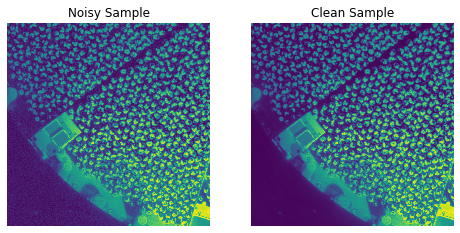

In [6]:
pair_show(training_data, 10)

In [7]:
class Img_Dataset(Dataset):
    def __init__(self, data_set, patch_size, seed=1234):
        self.data_set = data_set
        self.patch_size = patch_size
        self.seed = seed

    def __len__(self):
        return len(self.data_set[0])

    def __getitem__(self, idx):
        data = self.data_set
        image = data[0, idx]
        label = data[1, idx]
        
        patch_size = self.patch_size
        seed = self.seed
        rng = np.random.RandomState(seed)

        # img_width = 200
        # img_height = 200
        img_width = 1000
        img_height = 1000
        
        #randomly crop patch from training set
        x1 = rng.randint(img_width - patch_size)
        y1 = rng.randint(img_height - patch_size)
        S = (slice(y1, y1 + patch_size), slice(x1, x1 + patch_size))
        
        # create new arrays for training patchs
        image_patch = image[0][S]
        label_patch = label[0][S]
        
        image = torch.from_numpy(image_patch).float().cuda(device)
        label = torch.from_numpy(label_patch).float().cuda(device)
            
        return image, label

In [8]:
img_dataset = Img_Dataset(training_data, patch_size=50)
train_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 50, 50])
Labels batch shape: torch.Size([64, 50, 50])


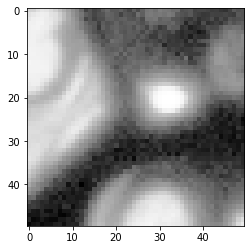

In [9]:
img = train_features[0][0].squeeze()
imgs = train_features.cpu().detach().numpy()
plt.imshow(imgs[0], cmap="gray")

In [10]:
def pair_show(dataloader, igen):
    """
    Plot to compare a training sample and its residual noise image
    
    Parameters
    ----------
    igen : int
           Index of specific sample of interest
    """
    
    train_features, train_labels = next(iter(train_dataloader))
    train_features = train_features.cpu().detach().numpy()
    train_labels = train_labels.cpu().detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(train_features[igen], origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample')
    ax[1].imshow(train_labels[igen], origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Clean Sample')

IndexError: index 340 is out of bounds for axis 0 with size 64

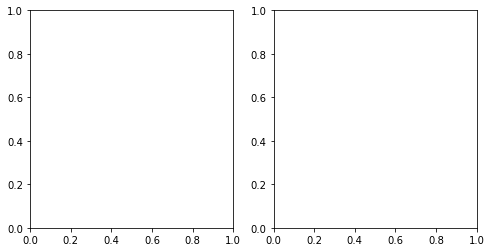

In [11]:
pair_show(train_dataloader, 340)